In [1]:
import pandas as pd
from google.colab import files
uploaded=files.upload()
df=pd.read_csv("TravelInsurancePrediction.csv")
df

Saving TravelInsurancePrediction.csv to TravelInsurancePrediction.csv


,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...
1982,1982,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes,1
1983,1983,28,Private Sector/Self Employed,Yes,1750000,5,1,No,Yes,0
1984,1984,28,Private Sector/Self Employed,Yes,1150000,6,1,No,No,0
1985,1985,34,Private Sector/Self Employed,Yes,1000000,6,0,Yes,Yes,1


In [9]:
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

     |████████████████████████████████| 82 kB 411 kB/s 
     |████████████████████████████████| 245 kB 4.2 MB/s 
     |████████████████████████████████| 675 kB 36.6 MB/s 
     |████████████████████████████████| 4.7 MB 38.0 MB/s 
     |████████████████████████████████| 62 kB 852 kB/s 
     |████████████████████████████████| 102 kB 46.6 MB/s 
     |████████████████████████████████| 812 kB 55.3 MB/s 
     |████████████████████████████████| 38.2 MB 24 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0452c735df92901653e9bd49e9410ea810accc3ec99e362350b3dd158f32f9f5
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=6a16fc7e732eed219e1748ad5e13f4e721c55cd53f2b1b00b407f5ac0c705b8b
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully b

In [3]:
#EDA 및 결측치 확인

df= df.iloc[:,1:]
df.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

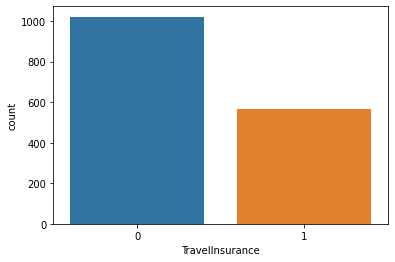

In [4]:
#target 정하기 
target = 'TravelInsurance'
features = df.columns.drop('TravelInsurance')

#train,test,val 데이터 나누기
from sklearn.model_selection import train_test_split
train,test = train_test_split(df, random_state=2, test_size=0.2)
test, val = train_test_split(test, random_state=2, test_size=0.4)

#타켓데이터 범주비율 확인
train.shape, val.shape, test.shape
train[target].value_counts(normalize=True)

y_train = train[target]
y_train.value_counts(normalize=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=y_train);

In [5]:
#카디널리티 확인
train.describe(exclude='number')
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Employment Type,1589,2,Private Sector/Self Employed,1152
GraduateOrNot,1589,2,Yes,1346
FrequentFlyer,1589,2,No,1259
EverTravelledAbroad,1589,2,No,1274


In [6]:
#데이터 분리

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test= test[target]

In [28]:
#기준모델 예측수행

major = y_train.mode()[0]
y_pred = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print("기준모델 학습모델 정확도 ", accuracy_score(y_train, y_pred))

y_val = val[target]
y_pred = [major] * len(y_val)
print("기준모델 검증세트 정확도 ", accuracy_score(y_val, y_pred))

기준모델 학습모델 정확도  0.6425424795468848
기준모델 검증세트 정확도  0.65625


In [10]:
#카테고리값 원핫인코딩으로 변환

from category_encoders import OneHotEncoder
encoder = OneHotEncoder(use_cat_names = True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_val=encoder.transform(X_val)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
# 타켓과 가장 correlated 된 features 선택

from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_val_selected = selector.transform(X_val)

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] 
print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['Age', 'Employment Type_Private Sector/Self Employed',
       'Employment Type_Government Sector', 'GraduateOrNot_No', 'AnnualIncome',
       'FamilyMembers', 'FrequentFlyer_No', 'FrequentFlyer_Yes',
       'EverTravelledAbroad_Yes', 'EverTravelledAbroad_No'],
      dtype='object')
Unselected names:  Index(['GraduateOrNot_Yes', 'ChronicDiseases'], dtype='object')


In [12]:
#관련성 적은 feature 삭제
X_train = X_train.drop('ChronicDiseases',axis=1)
X_val = X_val.drop('ChronicDiseases',axis=1)
X_test = X_test.drop('ChronicDiseases',axis=1)

로지스틱 회귀모델 검증세트 정확도 0.65625
Age                                            -2.416533e-10
Employment Type_Private Sector/Self Employed   -2.331581e-12
Employment Type_Government Sector              -6.056939e-12
GraduateOrNot_Yes                              -6.455376e-12
GraduateOrNot_No                               -1.933143e-12
AnnualIncome                                   -2.546712e-07
FamilyMembers                                  -3.419697e-11
FrequentFlyer_No                               -1.109090e-11
FrequentFlyer_Yes                               2.702383e-12
EverTravelledAbroad_Yes                         6.914726e-12
EverTravelledAbroad_No                         -1.530325e-11
dtype: float64


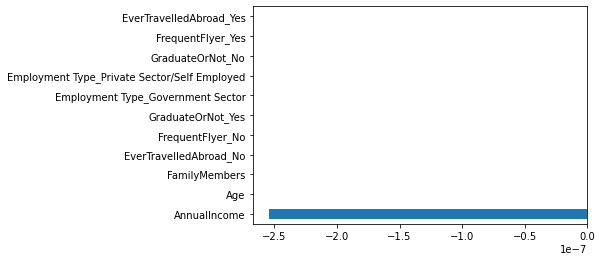

In [26]:
#로지스틱회귀모델 적용
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_val)
print('로지스틱 회귀모델 검증세트 정확도', accuracy_score(y_val, y_pred))

coefficients = pd.Series(logistic.coef_[0], X_train.columns)
print(coefficients)

coefficients.sort_values().plot.barh()

In [22]:
#랜덤포레스트모델 적용
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=2, oob_score=True)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('랜덤포레스트 검증세트 정확도: ', accuracy_score(y_val, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

랜덤포레스트 검증세트 정확도:  0.7875
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       105
           1       0.73      0.60      0.66        55

    accuracy                           0.79       160
   macro avg       0.77      0.74      0.75       160
weighted avg       0.78      0.79      0.78       160



In [13]:
#최적의 하이퍼파라미터 찾기

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists = {
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.6881020762023874, 'randomforestclassifier__n_estimators': 449}


In [29]:
#최적의 하이퍼파라미터 적용
pipe_r = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth=5, max_features= 0.6881020762023874, n_estimators=449, n_jobs=-1, random_state=2, oob_score=True)
)

pipe_r.fit(X_train, y_train)
y_pred = pipe_r.predict(X_val)
print('하이퍼파라미터 적용 검증세트 정확도: ', accuracy_score(y_val, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

하이퍼파라미터 적용 검증세트 정확도:  0.83125
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       105
           1       0.94      0.55      0.69        55

    accuracy                           0.83       160
   macro avg       0.87      0.76      0.79       160
weighted avg       0.85      0.83      0.82       160



In [30]:
#Gradiant Boosted Tree 모델 적용

from xgboost import XGBClassifier

pipe_g = make_pipeline(
    XGBClassifier(n_estimators=214
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=5
                  , learning_rate=0.1))

pipe_g.fit(X_train, y_train);
y_pred = pipe_g.predict(X_val)
print('그래디언트 부스트 트리 검증 정확도: ', accuracy_score(y_val, y_pred))
print(classification_report(y_pred, y_val))

그래디언트 부스트 트리 검증 정확도:  0.8375
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       125
           1       0.58      0.91      0.71        35

    accuracy                           0.84       160
   macro avg       0.78      0.87      0.80       160
weighted avg       0.89      0.84      0.85       160



In [32]:
#교차검증

from sklearn.model_selection import cross_val_score
k = 3
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print("교차검증:")
print(f'MAE for {k} folds:', -scores)
print("-scores mean:",-scores.mean())
print("scores std:", scores.std())

교차검증:
MAE for 3 folds: [0.22264151 0.19622642 0.20982987]
-scores mean: 0.2095659307343867
scores std: 0.010785531953322162


#특성중요도


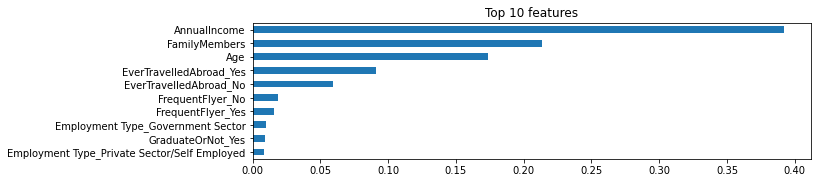

In [36]:
#특성 중요도

import matplotlib.pyplot as plt
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
print("#특성중요도")
n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();


In [22]:
pip install PDPbox

     |████████████████████████████████| 34.0 MB 41 kB/s 
     |████████████████████████████████| 13.1 MB 6.9 kB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=16870210777a1fc1d6e83ab54ebc76c169ce3e39c3e152fb430408df7136ee5f
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built PDPbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


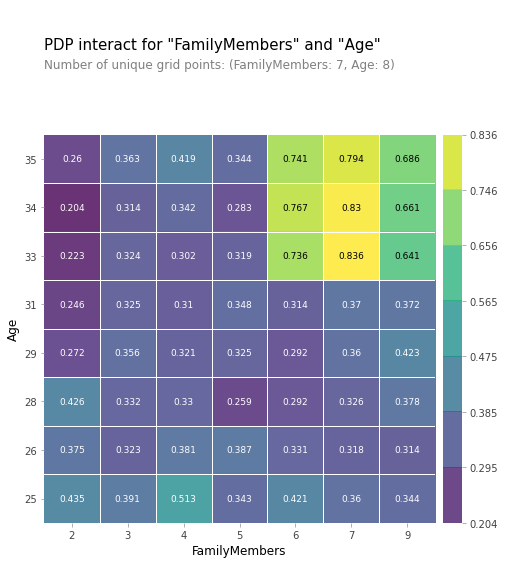

In [23]:
#PDP(가족구성원수와 나이 특성 2개 사용)

import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['FamilyMembers', 'Age']

interaction = pdp_interact(
    model=rf, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

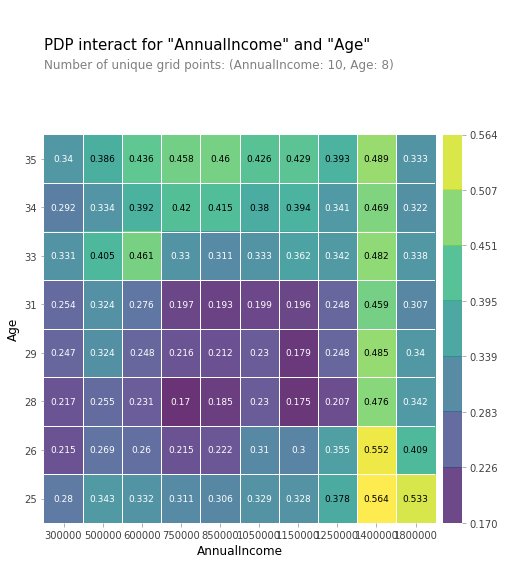

In [24]:
#PDP(연수입와 나이 특성 2개 사용)

import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['AnnualIncome', 'Age']

interaction = pdp_interact(
    model=rf, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);